# 설명 가능한 머신러닝

### 설명 가능한 AI
- 알고리즘이 도출한 결과에 대하여 설명 가능한 근거나 해석력을 보장하여 신뢰성과 투명성을 강화하려는 기술

### 기대효과
- 신뢰도 확보
- 컴플라이언스 요구 충족 (규제 대응)
- 학습결과의 일반화
- 머신러닝 모델의 개선
- 판단 과정의 편향 발견
- 새로운 지식을 가설로 검증
- AutoML 사용 시 데이터 분석가의 역할 확대

### XAI의 원리
- 0) 본질적으로 설명이 가능한 모델을 구축
- 1) 머신러닝 모델 전체에 대한 해석 제공
- 2) 머신러닝 모델에 쓰인 피처에 대한 해석 제공
- 3) 개별 데이터 포인트와 학습결과에 이르게 된 과정에 대한 해석 제공

### XAI 기법 소개
- 1) 피처 중요도
- 2) 부분 의존성
- 3) 대리 모델 : LIME, SHAP 등

# 머신러닝 모델에서 변수의 영향력 계산하기

- 패키지
  - pickle : 머신러닝 모델 아웃풋과 데이터 셋을 저장하고 불러오기
  - gzip : 파일 압축 및 해제
  - eli5 : 머신러닝 모델 설명 (Explain Like I am 5)
  - pdpbox : Partial dependence plot 학습 모델 설명, 시각화
  - lime : 학습한 결과를 대리 분석으로 설명


In [3]:
! pip install eli5
! pip install pdpbox
! pip install lime

     |████████████████████████████████| 112kB 2.9MB/s 
     |████████████████████████████████| 34.0MB 119kB/s 
     |████████████████████████████████| 13.1MB 20.1MB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.1-cp37-none-any.whl size=35758228 sha256=17c8b1037dc45566e891033b06ec86252ced7da96c2b6759667c4334cc61d8d3
  Stored in directory: /root/.cache/pip/wheels/c8/13/11/ecac74c6192790c94f6f5d919f1a388f927b9febb690e45eef
Successfully built pdpbox
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


     |████████████████████████████████| 276kB 2.9MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp37-none-any.whl size=283846 sha256=8f9e0405793a97ebfd3e328679e705ff549d7a0394533e84b9e80b8fad9e8f6e
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime


In [1]:
# 데이터 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pickle
import gzip
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
datapath = 'https://github.com/mchoimis/financialML/raw/main/xai/'

- 모델 및 데이터 설명
  - data00 : 이진분류용 데이터
  - data01 : 다중분류용 데이터
  - logreg : Logistic Regression Classifier
  - rfc : Random Forest Classifier
  - gbc : Gradient Boosting Classifier
  - lgbm : LightGBM Classifier

In [4]:
# 모델 데이터를 업로드할 구글 드라이브와 코랩 연결

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
# Create new folder
! mkdir financialml

In [5]:
# Get Present Working Directory
!pwd

/content


In [7]:
# 저장한 데이터와 모델 불러오기

modelpath = '/content/financialml/'

with gzip.open(modelpath + 'data00.pickle', 'rb') as f:
  data00 = pickle.load(f)
with gzip.open(modelpath + 'data00_X_train.pickle', 'rb') as f:
  X_train = pickle.load(f)
with gzip.open(modelpath + 'data00_X_test.pickle', 'rb') as f:
  X_test = pickle.load(f)
with gzip.open(modelpath + 'data00_y_train.pickle', 'rb') as f:
  y_train = pickle.load(f)
with gzip.open(modelpath + 'data00_y_test.pickle', 'rb') as f:
  y_test = pickle.load(f)

### 로지스틱 모델 회귀계수 해석하기

In [8]:
# Logistic Regression 이진분류 모델 불러오기
with open(modelpath + 'logreg00.pkl', 'rb') as file:
  logreg = pickle.load(file)

In [9]:
X_test.columns

Index(['age', 'workclass', 'education.num', 'marital.status', 'occupation',
       'relationship', 'race', 'sex', 'capital.gain', 'capital.loss',
       'hours.per.week', 'native.country'],
      dtype='object')

In [10]:
# 회귀계수 확인
logreg.coef_

array([[ 0.45435118, -0.08929983,  0.88011855, -0.37428934, -0.01347698,
        -0.19718355,  0.08082303,  0.43380857,  2.34127172,  0.27435968,
         0.37244795,  0.01498249]])

In [11]:
# 데이터 형태 변경

coef = sum(logreg.coef_)
coef

array([ 0.45435118, -0.08929983,  0.88011855, -0.37428934, -0.01347698,
       -0.19718355,  0.08082303,  0.43380857,  2.34127172,  0.27435968,
        0.37244795,  0.01498249])

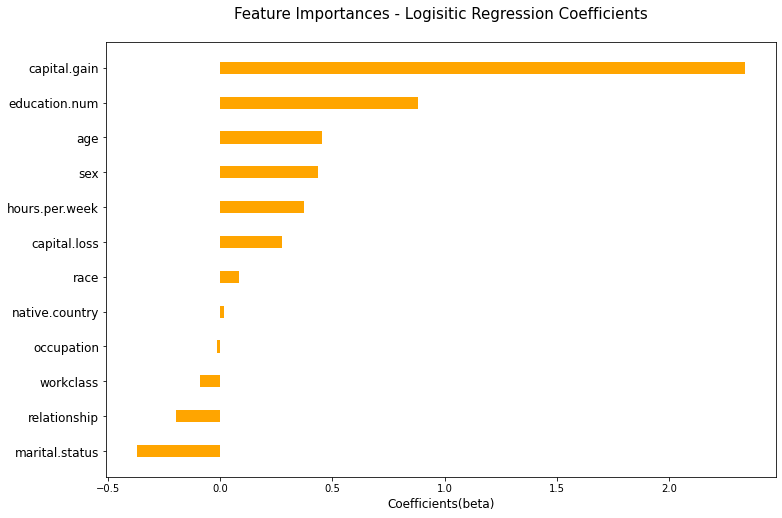

In [13]:
# 시각화

indices = np.argsort(coef) # 회귀계수 크기 순으로 정렬

plt.figure(figsize=(12, 8))
plt.barh(X_test.columns, coef[indices], .35, color='orange', align='center')
plt.yticks(X_test.columns, X_test.columns[indices], fontsize=12)
plt.xlabel('Coefficients(beta)', fontsize=12)
plt.title('Feature Importances - Logisitic Regression Coefficients\n', fontsize=15)
plt.show()

### 머신러닝 모델에서 변수의 영향력을 계산하는 방법

- 1) <b>회귀 모델의 회귀계수(Coefficients) </b>
    - X(피처)의 변량에 따라 y(타겟)의 변량이 어느 정도로 변하는지 수치화한 값
    - 변수 영향력의 방향(긍정, 부정)을 알 수 있다는 장점
    - 단점: 변수 스케일의 영향을 받기 때문에 스케일링 작업이 중요
    - scikit-learn의 `coef_` 메서드 사용


- 2) <b>트리 기반 모델의 MDI(Mean Decrease Impurity) 기반 중요도 </b>
    - 해당 피처가 모델에 적용될 때 전체적으로 분류 결과의 불순도(impurity)를 얼마나 감소시키는지를 측정
    - 불순도(impurity)의 측정 방법은 주로 entropy 혹은 Gini impurity로 계산
    - 피처가 모델이 분류를 잘 하는데 중요하게 작용할 수록 값이 커지게 됨
    - scikit-learn의 `feature_importances_` 메서드 사용


- 3) <b>치환(Permutation) 기반 중요도 </b>
    - 특정 피처의 값을 임의의 값으로 치환했을 떄 원래 데이터보다 예측 에러가 얼마나 더 커지는가를 측정 
    - 장점: 해석이 직관적이며, 계산에 시간이 오래 걸리지 않음
    - 단점: 변수간 상호의존성 때문에 특정 피처의 영향력을 과대 혹은 과소추정할 수 있음
    - scikit-learn의 `permutation_importance` 메서드 사용
    - eli5의 `PermutationImportance` 메서드 사용


- 4) <b>LGBM 모델의 분기 기반 중요도</b>
    - 기본값으로는 각 피처에서 결정을 내리기까지 분기(split)한 횟수를 나타냄
    - 파라미터 설정을 바꾸면 분기에서 얻어낸 정보 이득(gain)의 총합을 나타낼 수 있음
    - scikit-learn의 `feature_importances_` 메서드 사용
    - light gbm의 `plot_importance` 메서드 사용 


- 5) <b>XAI 커뮤니티에서 제안하는 게임이론 기반 Shapely 값</b>
    - 치환 피처 중요도(Permutation Importance)와 비슷하게 임의의 값으로 치환했을 때의 pay-off를 측정
    - 장점: 변수간 상호의존성에 영향을 받지 않으며, 계산시마다 값이 달라지지 않음, 변수 영향력의 방향(긍정, 부정)을 알 수 있음
    - 단점: 학습결과가 아니라 원 데이터에서 결정되기 때문에 아웃라이어에 약할 수 있음, 계산이 오래 걸림
    - shap의 `shap_values` 메서드 사용

각 방법론은 장단점이 뚜렷하고 계산방식이 다르므로 머신러닝 모델 해석시 상황에 맞게 적용하는 것이 중요.

### Random Forest 이진분류 피처 중요도 분석하기

In [14]:
# Random Forest Classifier 이용하여 모델 fitting

from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(random_state=42).fit(X_train, y_train)


In [15]:
# 모델 저장하기

pickle.dump(rfc, open(modelpath + 'rfc00.pkl', 'wb'))

In [16]:
# 모델 불러오기
with open(modelpath + 'rfc00.pkl', 'rb') as file:
  rfc = pickle.load(file)

In [17]:
# Random Forest 이진분류 모델의 피쳐 중요도 확인하기

importances = rfc.feature_importances_
importances

array([0.2120391 , 0.04862643, 0.14503283, 0.05946474, 0.08394042,
       0.12762821, 0.01853742, 0.01328217, 0.12340054, 0.0394054 ,
       0.10993623, 0.0187065 ])

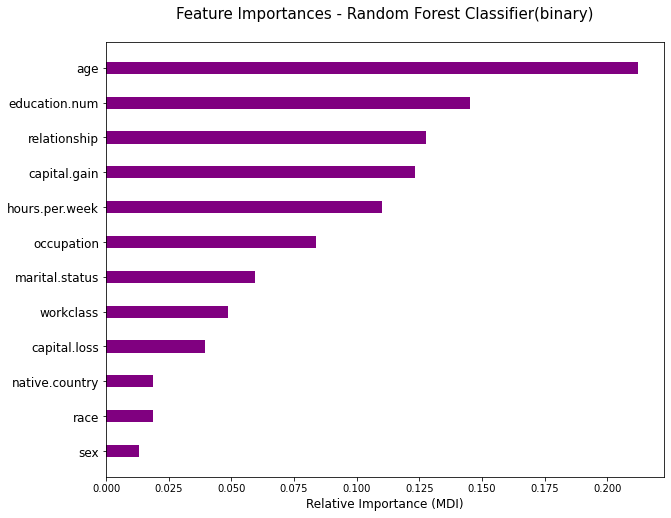

In [19]:
# 시각화

indices = np.argsort(importances)

plt.figure(figsize=(10, 8))
plt.barh(X_test.columns, importances[indices], .35, color='purple', align='center')
plt.yticks(X_test.columns, X_test.columns[indices], fontsize=12)
plt.xlabel('Relative Importance (MDI)', fontsize=12)
plt.title('Feature Importances - Random Forest Classifier(binary)\n', fontsize=15)
plt.show()

### Eli5를 이용하여 Permutation Importance 구하기
- 각 Feature별로 Shuffling을 하였을 때 Model의 Accuracy를 기준으로 반복하면서 발생한 데이터의 변동까지 표기 후 내림차순으로 정리한 결과값

###  Random Forest 모델의 Permutation Importance 구하기

In [20]:
import eli5
from eli5.sklearn import PermutationImportance

imp = PermutationImportance(rfc, random_state = 1).fit(X_test, y_test)
imp

PermutationImportance(cv='prefit',
                      estimator=RandomForestClassifier(bootstrap=True,
                                                       ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=None,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fr

In [21]:
# 피처 중요도 순서대로 확인하기

eli5.show_weights(imp, feature_names = X_test.columns.tolist())

Weight,Feature
0.0455 ± 0.0031,capital.gain
0.0279 ± 0.0072,relationship
0.0238 ± 0.0020,education.num
0.0121 ± 0.0062,age
0.0104 ± 0.0018,capital.loss
0.0103 ± 0.0051,occupation
0.0046 ± 0.0017,workclass
0.0044 ± 0.0047,hours.per.week
0.0016 ± 0.0022,marital.status
0.0007 ± 0.0018,sex


In [22]:
# 중요도 리스트로 뽑아내기

print(eli5.format_as_text(eli5.explain_weights(imp, feature_names = X_test.columns.tolist())))

Explained as: feature importances

Feature importances, computed as a decrease in score when feature
values are permuted (i.e. become noise). This is also known as 
permutation importance.

If feature importances are computed on the same data as used for training, 
they don't reflect importance of features for generalization. Use a held-out
dataset if you want generalization feature importances.

0.0455 ± 0.0031  capital.gain
0.0279 ± 0.0072  relationship
0.0238 ± 0.0020  education.num
0.0121 ± 0.0062  age
0.0104 ± 0.0018  capital.loss
0.0103 ± 0.0051  occupation
0.0046 ± 0.0017  workclass
0.0044 ± 0.0047  hours.per.week
0.0016 ± 0.0022  marital.status
0.0007 ± 0.0018  sex
0.0002 ± 0.0011  race
-0.0002 ± 0.0015  native.country


### Gradient Boosting 이진분류 피쳐 중요도 분석하기

In [23]:
# Gradient Boosting 이진분류 모델 불러오기

with open(modelpath + 'gbc00.pkl', 'rb') as file:
    gbc = pickle.load(file) 

In [24]:
# Gradient Boosting 이진분류 모델의 피처 중요도 확인하기

importances =  gbc.feature_importances_
importances  ###

array([5.87837092e-02, 5.51372125e-03, 2.10092686e-01, 4.33635936e-02,
       1.92692089e-02, 3.34315886e-01, 3.03009270e-04, 4.93262744e-03,
       2.22621605e-01, 6.02590869e-02, 3.97442162e-02, 8.00649340e-04])

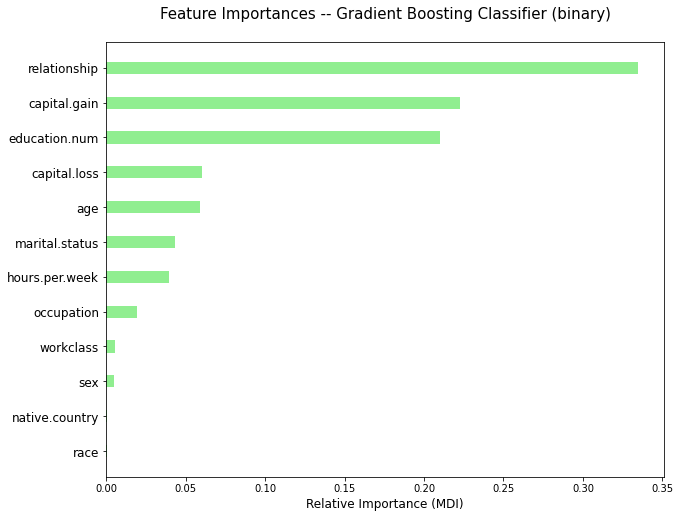

In [25]:
# Gradient Boosting 이진분류 모델의 피처 중요도 시각화 하기

indices = np.argsort(importances)  # 중요도 크기 순으로 정렬

plt.figure(figsize=(10, 8))

plt.barh(X_test.columns, importances[indices], .35, color='lightgreen', align='center')
plt.yticks(X_test.columns, X_test.columns[indices], fontsize=12)

plt.xlabel('Relative Importance (MDI)', fontsize=12)
plt.title('Feature Importances -- Gradient Boosting Classifier (binary)\n', fontsize=15)
plt.show()

### LightGBM 이진분류 피처 중요도 분석하기

In [26]:
# LightGBM 이진분류 모델 불러오기

with open(modelpath + 'lgbm00.pkl', 'rb') as file:
    lgbm =  pickle.load(file)

In [27]:
# LightGBM 이진분류 모델의 피처 중요도 확인하기 ## 피처별 분기한 회수

importances =  lgbm.feature_importances_
importances ###

array([611, 174, 332, 162, 329, 150,  63,  50, 378, 264, 398,  89])

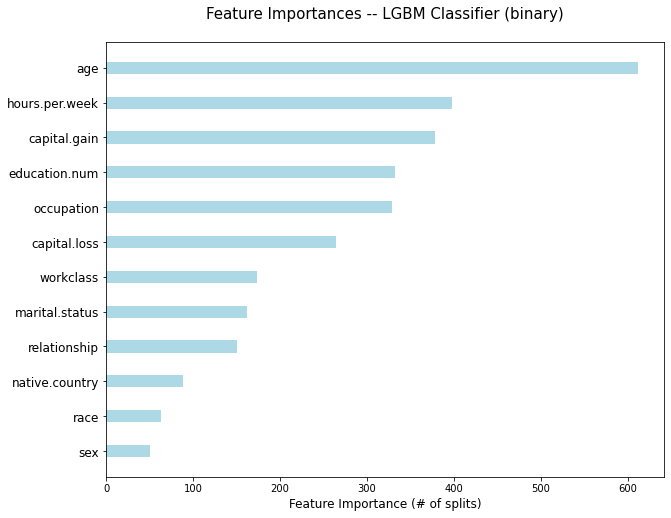

In [28]:
# LightGBM 이진분류 모델의 피처 중요도 시각화 하기

indices = np.argsort(importances)   # 중요도 크기 순으로 정렬

plt.figure(figsize=(10, 8))

plt.barh(X_test.columns, importances[indices], .35, color='lightblue', align='center')
plt.yticks(X_test.columns, X_test.columns[indices], fontsize=12)

plt.xlabel('Feature Importance (# of splits)', fontsize=12)
plt.title('Feature Importances -- LGBM Classifier (binary)\n', fontsize=15)
plt.show()

### 요약: 소득 예측 이진분류 모델 피처 중요도 비교

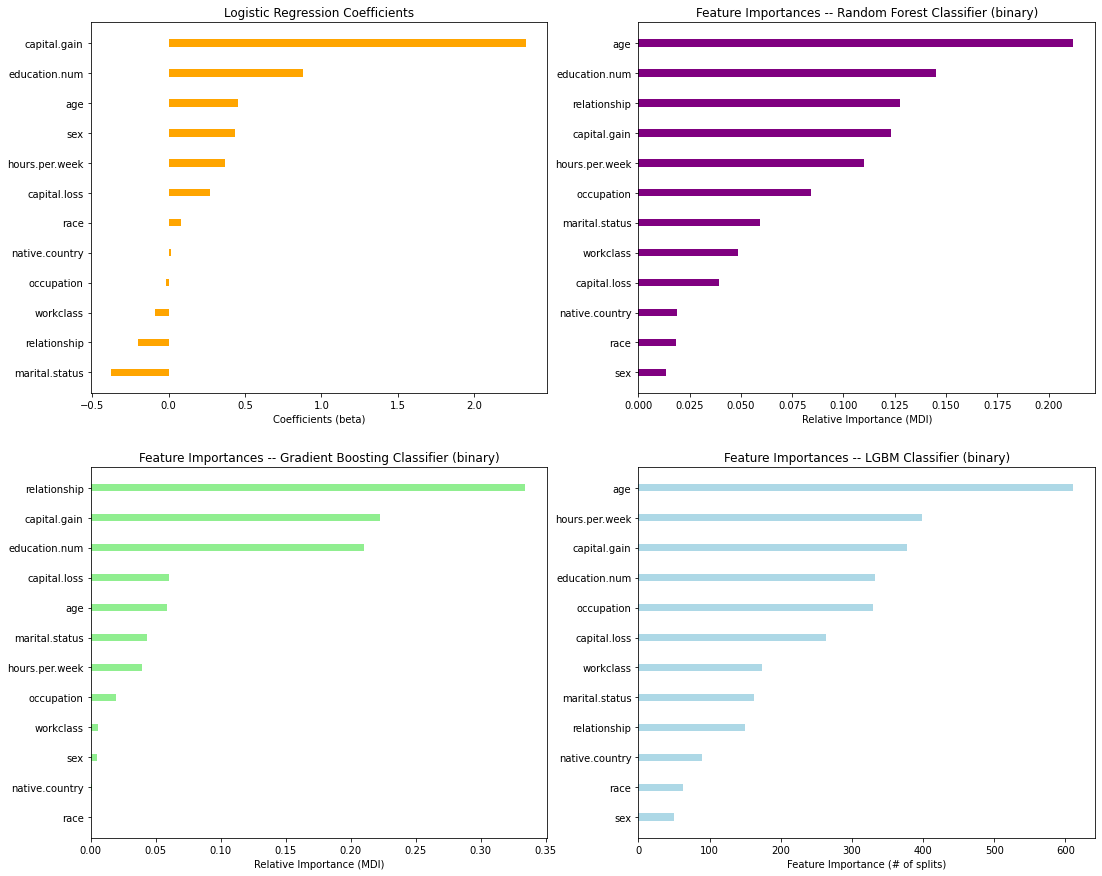

In [29]:
# subplot을 이용하여 4개 이진분류 모델(logreg, gbc, rfc, lgbm)의 회귀계수 및 피처 중요도 시각화 비교하기

plt.figure(figsize=(18, 15))

plt.subplot(2, 2, 1) 
indices_logreg = np.argsort(coef)   ###

plt.title('Logistic Regression Coefficients')
plt.barh(X_test.columns, coef[indices_logreg], .25, color='orange')
plt.yticks(X_test.columns, X_test.columns[indices_logreg])
plt.xlabel('Coefficients (beta)')

plt.subplot(2, 2, 2)
importances_rfc = rfc.feature_importances_  ###
indices_rfc = np.argsort(importances_rfc)  ###

plt.title('Feature Importances -- Random Forest Classifier (binary)')
plt.barh(X_test.columns, importances_rfc[indices_rfc], .25, color='purple')
plt.yticks(X_test.columns, X_test.columns[indices_rfc])
plt.xlabel('Relative Importance (MDI)')

plt.subplot(2, 2, 3)
importances_gbc = gbc.feature_importances_  ###
indices_gbc =  np.argsort(importances_gbc)  ###

plt.title('Feature Importances -- Gradient Boosting Classifier (binary)')
plt.barh(X_test.columns, importances_gbc[indices_gbc], .25, color='lightgreen')
plt.yticks(X_test.columns, X_test.columns[indices_gbc])
plt.xlabel('Relative Importance (MDI)')

plt.subplot(2, 2, 4)
importances_lgbm = lgbm.feature_importances_  ###
indices_lgbm = np.argsort(importances_lgbm)  ###

plt.title('Feature Importances -- LGBM Classifier (binary)')
plt.barh(X_test.columns, importances_lgbm[indices_lgbm], .25, color='lightblue')
plt.yticks(X_test.columns, X_test.columns[indices_lgbm])
plt.xlabel('Feature Importance (# of splits)')

plt.show()

### 참고: 기법별로 설명이 상충될 때 모델 해석방법

피처 중요도의 순서가 꼭 의사결정 트리의 순서를 결정하는 것은 아님.

트리는 노드의 선정과 분기 기준이 정보 이득(information gain)이 큰 방향이고, 피처 중요도는 모델의 분류 에러가 큰 순서로 정렬되기 때문.

### 다중분류 Random Forest 피처 중요도 분석하기

In [30]:
# 분석에 사용할 데이터 불러오기

with gzip.open(modelpath + 'data01.pickle','rb') as f:
    data01 =  pickle.load(f)
with gzip.open(modelpath + 'data01_X_train.pickle','rb') as f:
    x_train = pickle.load(f)
with gzip.open(modelpath + 'data01_X_test.pickle','rb') as f:
    x_test =  pickle.load(f)
with gzip.open(modelpath + 'data01_y_train.pickle','rb') as f:
    y_train01 =  pickle.load(f)     ## 
with gzip.open(modelpath + 'data01_y_test.pickle','rb') as f:
    y_test01 =   pickle.load(f)     ##

In [31]:
# 모델을 선언하고 fitting 하기

rfc1 = RandomForestClassifier().fit(x_train, y_train)

In [32]:
x_test.columns

Index(['age', 'workclass', 'education.num', 'marital.status', 'occupation',
       'relationship', 'sex', 'capital.gain', 'capital.loss', 'hours.per.week',
       'spend.groc', 'spend.med', 'spend.trav', 'asset', 'balance',
       'native.country'],
      dtype='object')

In [33]:
# Random Forest 다중분류 모델의 피처 중요도 확인
importances = rfc1.feature_importances_
importances

array([0.04370935, 0.00991974, 0.08850434, 0.07023974, 0.01979617,
       0.09505612, 0.0049265 , 0.09035055, 0.02041021, 0.03067271,
       0.18669911, 0.23129357, 0.03089736, 0.02721554, 0.0443486 ,
       0.00596038])

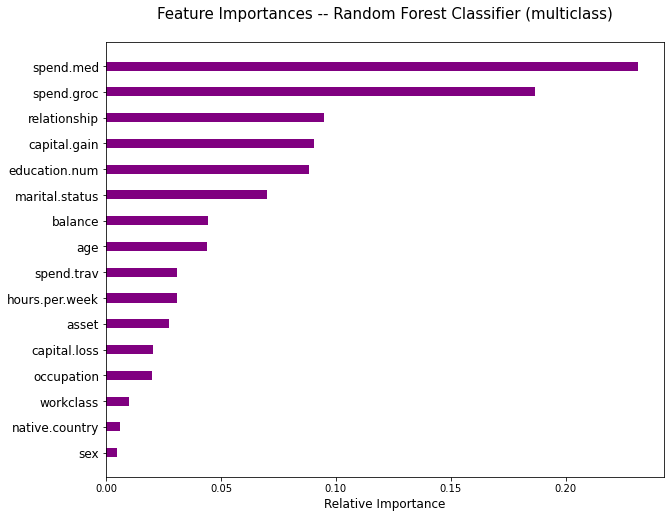

In [34]:
# Random Forest 다중분류 모델의 피처 중요도 시각화 하기

indices = np.argsort(importances)  # 중요도 크기 순으로 정렬

plt.figure(figsize=(10, 8))
plt.barh(x_test.columns, importances[indices], .35, color='purple', align='center')
plt.yticks(x_test.columns, x_test.columns[indices], fontsize=12)
plt.xlabel('Relative Importance', fontsize=12)
plt.title('Feature Importances -- Random Forest Classifier (multiclass)\n', fontsize=15)
plt.show()

### 다중분류 LGBM 피처 중요도 분석하기

In [35]:
# 미리 저장한 LGBM 다중분류 모델 불러오기

with open(modelpath + 'lgbm01.pkl', 'rb') as file:
    lgbm1 =  pickle.load(file)

In [36]:
# LGBM 다중분류 모델의 피처 중요도 확인하기

importances =  lgbm1.feature_importances_
importances

array([ 601,  170,  267,  123,  293,  155,   45,   84,   61,  350,  792,
        715, 5074, 1728, 4446,   96])

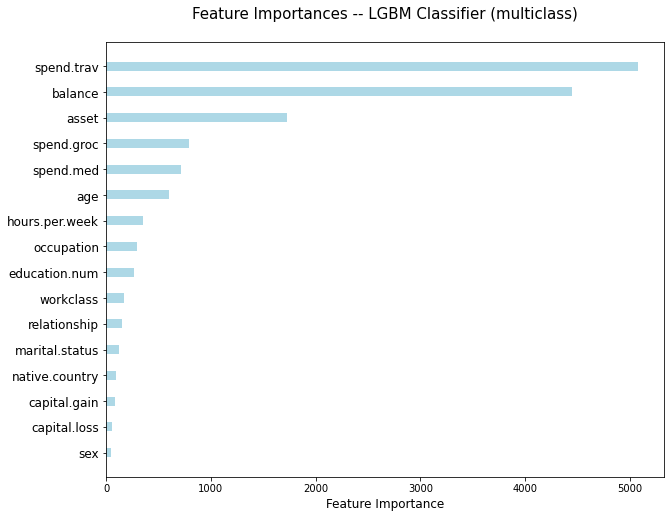

In [37]:
# LGBM 다중분류 모델의 피처 중요도 시각화 하기

indices =  np.argsort(importances)                  # 중요도 크기 순으로 정렬

plt.figure(figsize=(10, 8))
plt.barh(x_test.columns, importances[indices], .35, color='lightblue', align='center')
plt.yticks(x_test.columns, x_test.columns[indices], fontsize=12)

plt.xlabel('Feature Importance', fontsize=12)
plt.title('Feature Importances -- LGBM Classifier (multiclass)\n', fontsize=15)
plt.show()

### 요약: 다중분류 피처 중요도 비교

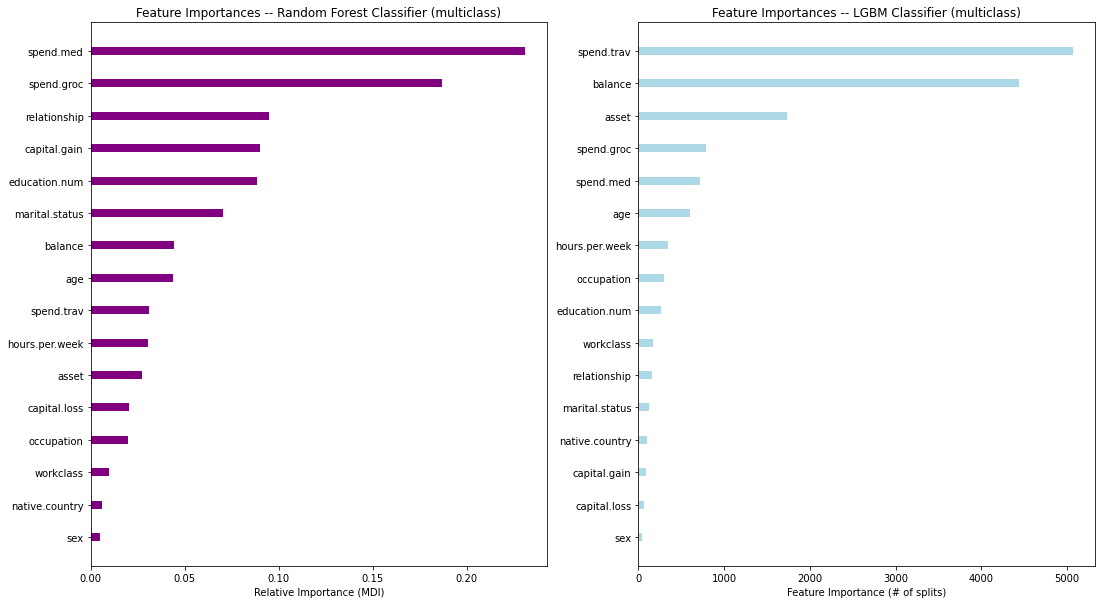

In [38]:
# subplot을 이용하여 2개 이진분류 모델(rfc1, lgbm1)의 피처 중요도 시각화 비교하기

plt.figure(figsize=(18, 10))

plt.subplot(1, 2, 1) 
importances_rfc = rfc1.feature_importances_  ###
indices_rfc = np.argsort(importances_rfc)  ###

plt.title('Feature Importances -- Random Forest Classifier (multiclass)')
plt.barh(x_test.columns, importances_rfc[indices_rfc], .25, color='purple')
plt.yticks(x_test.columns, x_test.columns[indices_rfc])
plt.xlabel('Relative Importance (MDI)')

plt.subplot(1, 2, 2)
importances_lgbm = lgbm1.feature_importances_  ###
indices_lgbm = np.argsort(importances_lgbm)  ###

plt.title('Feature Importances -- LGBM Classifier (multiclass)')
plt.barh(x_test.columns, importances_lgbm[indices_lgbm], .25, color='lightblue')
plt.yticks(x_test.columns, x_test.columns[indices_lgbm])
plt.xlabel('Feature Importance (# of splits)')

plt.show()

### 참고: 모델 해석방법

일반적으로 피처 중요도와 의사결정 트리 분기 순서는 대부분 일치. 

그러나 피처 중요도는 트리 깊이에 따라서도 바뀜. 
즉, 학습 파라미터에 따라 모델의 의사결정 방식과 정확도가 함께 변하기 때문에 피처 중요도 그래프의 순서가 소득구간을 예측하는 우선순위라고 판단할 수는 없음. 

그렇지만 피처 중요도의 순서가 소득구간 예측에 영향을 미치는 정도를 구분한다는 해석은 가능하다고 볼 수 있음. 